In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from torch.distributions import MultivariateNormal
import ipywidgets as widgets
from matplotlib.widgets import Cursor
from ipywidgets import interactive_output, VBox, Label, FloatSlider

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate S-curve dataset
data, _ = make_s_curve(n_samples=10000, noise=0.1, random_state=42)

# Use only the first and third dimension
data = data[:, [0, 2]]

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [3]:
class AffineCouplingLayer(nn.Module):
    def __init__(self):
        super(AffineCouplingLayer, self).__init__()
        
        self.s_net = nn.Sequential(
            # first layer: 
            nn.Linear(1, 256),
            nn.ReLU(),
            # second layer: 
            nn.Linear(256, 1),
            nn.Tanh()
        )
        
        self.t_net = nn.Sequential(
            # first layer:
            nn.Linear(1, 128),
            nn.ReLU(),
            # second layer: 
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        s = self.s_net(x1)
        t = self.t_net(x1)
        y2 = x2 * torch.exp(s) + t
        y1 = x1
        
        # 以下两种log(det(J))的计算方式是等价的，因为s为单个数字，求和其实没有作用
        # log_det_jacobian = s.view(s.size(0), -1).sum(dim=1)
        log_det_jacobian = torch.flatten(s)
        
        return y1, y2, log_det_jacobian

    def inverse(self, y1, y2):
        s = self.s_net(y1)
        t = self.t_net(y1)
        x2 = (y2 - t) * torch.exp(-s)
        x1 = y1
        
        # log_det_jacobian = -s.view(s.size(0), -1).sum(dim=1)
        log_det_jacobian = torch.flatten(-s)
        
        return x1, x2, log_det_jacobian

In [4]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([AffineCouplingLayer() for _ in range(8)])

    def forward(self, x):
        log_det_jacobian = 0
        x1, x2 = x.chunk(2, dim=1)

        for i, layer in enumerate(self.layers):
            if i % 2 == 0:
                y1, y2, ldj = layer(x1, x2)
                x1, x2 = y1, y2
                
            else:
                y2, y1, ldj = layer(x2, x1)
                x1, x2 = y1, y2
                
            log_det_jacobian += ldj

        return torch.cat([y1, y2], dim=1), log_det_jacobian

    def inverse(self, y):
        log_det_jacobian = 0
        y1, y2 = y.chunk(2, dim=1)

        for i, layer in enumerate(reversed(self.layers)):
            if i % 2 == 0:
                x2, x1, ldj = layer.inverse(y2, y1)
                y1, y2 = x1, x2
                
            else:
                x1, x2, ldj = layer.inverse(y1, y2)
                y1, y2 = x1, x2
                
            log_det_jacobian += ldj

        return torch.cat([x1, x2], dim=1), log_det_jacobian

In [5]:
model = torch.load('model_06.pth')

model.eval()
z, _ = model(torch.tensor(data, dtype=torch.float32))
z = z.detach().numpy()

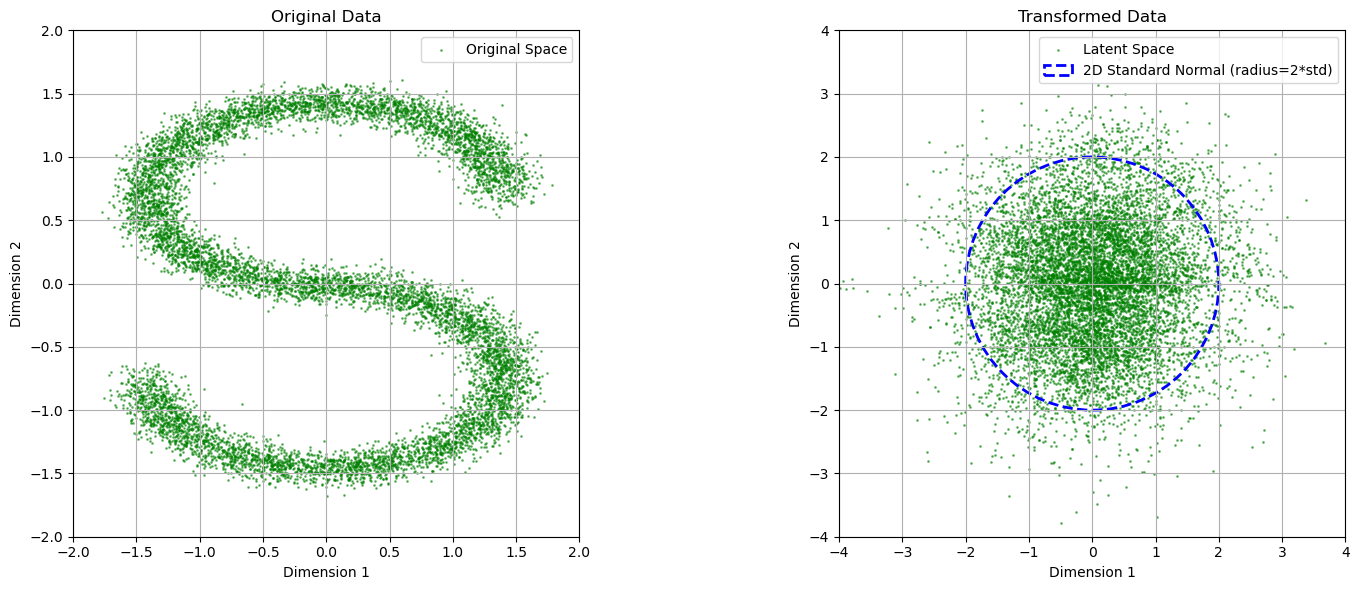

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 绘制原始数据
ax[0].scatter(data[:, 0], data[:, 1], s=1, c='green', alpha=0.5, label='Original Space')
ax[0].set_title('Original Data')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].grid(True)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_aspect('equal', adjustable='box')
ax[0].legend()


# 绘制转换后的数据
ax[1].scatter(z[:, 0], z[:, 1], s=1, c='green', alpha=0.5, label='Latent Space')

# 添加表示标准双变量正态分布的圆圈
circle = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, linestyle='--', label='2D Standard Normal (radius=2*std)')
ax[1].add_artist(circle)

ax[1].set_title('Transformed Data')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].grid(True)
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[1].set_aspect('equal', adjustable='box')
ax[1].legend()

plt.tight_layout()
plt.show()

In [38]:




def plot_all(x_1, x_2):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制原始数据
    ax[0].scatter(data[:, 0], data[:, 1], s=1, c='green', alpha=0.5, label='Original Space')
    ax[0].scatter(x_1, x_2, color='red', s=100, edgecolors='black', label='Observed Point')
    ax[0].set_title('Original Data')
    ax[0].set_xlabel('Dimension 1')
    ax[0].set_ylabel('Dimension 2')
    ax[0].grid(True)
    ax[0].set_xlim(-2, 2)
    ax[0].set_ylim(-2, 2)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].legend()

    # 转换坐标
    observed_point = np.array([[x_1, x_2]])  # 注意：现在是2D张量
    model.eval()
    latent_point, _ = model(torch.tensor(observed_point, dtype=torch.float32))
    latent_point = latent_point.detach().numpy()

    # 绘制转换后的数据
    ax[1].scatter(z[:, 0], z[:, 1], s=1, c='green', alpha=0.5, label='Latent Space')
    ax[1].scatter(latent_point[0, 0], latent_point[0, 1], color='red', s=100, edgecolors='black', label='Transformed Point')
    circle = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, linestyle='--', label='2D Standard Normal (radius=2*std)')
    ax[1].add_artist(circle)
    ax[1].set_title('Transformed Data')
    ax[1].set_xlabel('Dimension 1')
    ax[1].set_ylabel('Dimension 2')
    ax[1].grid(True)
    ax[1].set_xlim(-4, 4)
    ax[1].set_ylim(-4, 4)
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# 创建滑动条
x1_slider = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.1, description='X1:')
x2_slider = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.1, description='X2:')

# 创建交互式控件
ui = VBox([Label('Adjust the observed point:'), x1_slider, x2_slider])
interactive_plot = interactive_output(plot_all, {'x_1': x1_slider, 'x_2': x2_slider})

display(ui, interactive_plot)


Output()